# Re-load predictions and compare with true labels

### import modules

In [1]:
%matplotlib inline

In [2]:
import os
import fnmatch

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn import preprocessing, model_selection, metrics
from nilearn import plotting

import pickle

In [3]:
sns.set_style('white')
sns.set_context('poster')

### load labeler

In [4]:
myLabeler = pickle.load(open('../models/myLabeler.p', 'rb'))

In [5]:
myLabeler.classes_

array(['bilateral', 'inconclusive', 'left', 'right'], dtype=object)

### load list with patients

In [6]:
my_train = pickle.load(open('../models/my_nest.p', 'rb'))
my_test = pickle.load(open('../models/my_test.p', 'rb'))

In [7]:
len(my_train), len(my_test)

(521, 262)

In [8]:
def makeDf(dimStr, dropStr, my_split=my_test):
    df = pd.DataFrame()

    for pGroup, pName in my_split:
        try:
            csv = '../data/processed/csv/meanTable_%s.csv' % pName

            pDf = pd.read_csv(csv, index_col=[0, 1], header=0)
            pDf = pDf.loc[dimStr, :].loc[[dropStr], :]
            pDf.index = [[pGroup], [pName]]

            df = pd.concat([df, pDf])
        except:
            print 'no valid data for %s %s!'%(pGroup, pName)

    df.sort_index(inplace=True)

    df.drop(['L+R', 'L-R', 'LI'], axis=1, inplace=True)

    if dropStr == 'drop':
        df.drop('inconclusive', axis=0, inplace=True)
        df.drop('inconclusive', axis=1, inplace=True)

    return df

In [9]:
testDf = makeDf('1d', 'drop')

In [ ]:
testDf.tail()

In [11]:
predDf = pd.DataFrame(testDf.idxmax(axis=1))
predDf.columns = ['pred']
predDf.sort_index(inplace=True)

In [ ]:
predDf.tail()

In [13]:
y_true = [
    myLabeler.transform([predDf.index.levels[0][x]])[-1]
    for x in predDf.index.labels[0]
]
y_pred = myLabeler.transform(predDf['pred'])

In [14]:
print y_true
print y_pred

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2 0 2 2 2 0 0 0 2 2 0 2 0 0 0 0 0 0 2 0 2 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2

In [15]:
cm =  metrics.confusion_matrix(y_true,y_pred)

In [16]:
cm

array([[ 16,   9,   0],
       [  8, 168,   0],
       [  3,   0,  13]])

In [17]:
def makeCm(predDf, myLabeler=myLabeler):

    y_true = [
        myLabeler.transform([predDf.index.levels[0][x]])[-1]
        for x in predDf.index.labels[0]
    ]
    y_pred = myLabeler.transform(predDf['pred'])
    cm = metrics.confusion_matrix(y_true, y_pred)

    # put into df
    cmDf = pd.DataFrame(cm)

    # get the naming right
    try:
        theseLabels = myLabeler.inverse_transform(np.unique(y_true))
        cmDf.index = theseLabels
        cmDf.columns = theseLabels
    except:
        theseLabels = myLabeler.classes_
        cmDf.index = theseLabels
        cmDf.columns = theseLabels

    # make better order
    try:
        theseLabels = ['left', 'bilateral', 'right', 'inconclusive']
        cmDf = cmDf.reindex(index=theseLabels)
        cmDf = cmDf.reindex(columns=theseLabels)
        cmDf.index = [['True label'] * cmDf.shape[0], theseLabels]
        cmDf.columns = [['Predicted label'] * cmDf.shape[1], theseLabels]
    except:
        theseLabels = ['left', 'bilateral', 'right']
        cmDf = cmDf.reindex(index=theseLabels)
        cmDf = cmDf.reindex(columns=theseLabels)
        cmDf.index = [['True label'] * cmDf.shape[0], theseLabels]
        cmDf.columns = [['Predicted label'] * cmDf.shape[1], theseLabels]

    return cmDf

In [18]:
cmDf = makeCm(predDf)

In [19]:
cmDf

Predicted label                             
                                   left bilateral right inconclusive
True label left                   168.0       8.0   0.0          NaN
           bilateral                9.0      16.0   0.0          NaN
           right                    0.0       3.0  13.0          NaN
           inconclusive             NaN       NaN   NaN          NaN

In [20]:
def makeScaleCm(cmDf):
    return (cmDf.astype(float).T / cmDf.sum(axis=1)).T

In [21]:
cmScaleDf = makeScaleCm(cmDf)

In [22]:
cmScaleDf

Predicted label                               
                                   left bilateral   right inconclusive
True label left                0.954545  0.045455  0.0000          NaN
           bilateral           0.360000  0.640000  0.0000          NaN
           right               0.000000  0.187500  0.8125          NaN
           inconclusive             NaN       NaN     NaN          NaN

sanity check: true labels for each class should add up to one

In [23]:
cmScaleDf.T.sum()

True label  left            1.0
            bilateral       1.0
            right           1.0
            inconclusive    NaN
dtype: float64

### get diagonal (correct answers only)

In [24]:
def makeDiagCm(cmDf, idx):

    # get diagonal
    diagDf = pd.DataFrame(np.diagonal(cmDf)).T
    diagDf.index = idx
    diagDf.columns = cmDf.columns

    return diagDf

In [25]:
diagDf = makeDiagCm(cmDf, [['diag'], [0]])
diagDf

Predicted label                             
                  left bilateral right inconclusive
diag 0           168.0      16.0  13.0          NaN

### get accuracy from diagonal

In [26]:
def getAcc(cmDf, drop=True):

    # get absolute count of hits (diagonal)
    n_diag = makeDiagCm(cmDf, [['total'], ['total']]).sum(axis=1).values[-1]

    # get absolute count of all test data
    n_total = cmDf.sum().sum()

    # get proportion
    prop = n_diag / float(n_total)

    return pd.DataFrame([prop], index=['acc']).T

In [27]:
getAcc(cmDf, drop=True)

,acc
0,0.907834


In [28]:
metrics.accuracy_score(y_true, y_pred)

0.90783410138248843

### make nice plots

This is used to define a different color for the diagnoal

In [29]:
copyDf = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]).astype(bool)
copyDf = pd.DataFrame(copyDf)
copyDf.index = cmScaleDf.index
copyDf.columns = cmScaleDf.columns

In [30]:
copyDf

Predicted label                              
                                   left bilateral  right inconclusive
True label left                    True     False  False        False
           bilateral              False      True  False        False
           right                  False     False   True        False
           inconclusive           False     False  False         True

In [31]:
def makeCmAx(predDf, ax, copyDf=copyDf):

    cmTest = makeCm(predDf)
    cmScaleTest = makeScaleCm(cmTest)
    sns.heatmap(
        (cmScaleTest * 100).round(0),  # in percent...
        annot=True,
        cmap='Reds',
        vmin=0,
        vmax=100,
        cbar=False,
        annot_kws={"fontsize": 26},
        square=True,
    )

    # just the diagonal
    cmScaleTestDiag = cmScaleTest[copyDf]
    sns.heatmap(
        (cmScaleTestDiag * 100).round(0),  # in percent...
        annot=True,
        cmap='Blues',
        vmin=0,
        vmax=100,
        cbar=False,
        annot_kws={"fontsize": 26},
        square=True,
    )
    ax.set_xticklabels([
        cmScaleTest.columns.levels[1][x][0].upper()
        for x in cmScaleTest.columns.labels[1]
    ],
                       fontsize=24,
                       rotation=360)
    ax.set_yticklabels(
        [
            cmScaleTest.index.levels[1][x][0].upper()
            for x in cmScaleTest.index.labels[1]
        ][::-1],
        fontsize=24,
        rotation=360)

    ax.set_xlabel('Predicted', fontsize=24)
    ax.set_ylabel('True', fontsize=24)
    try:
        print getAcc(cmTest, drop=True)
    except:
        print getAcc(cmTest, drop=False)

    return ax

        acc
0  0.907834


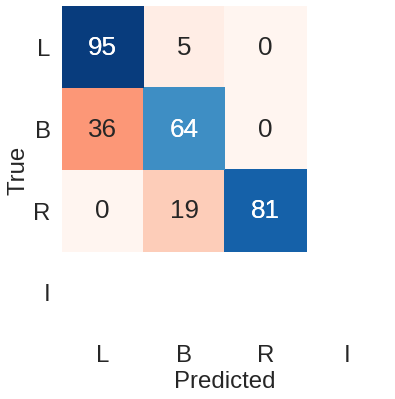

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = makeCmAx(predDf, ax)
plt.show()

1d drop
(217, 1)
        acc
0  0.907834
1d full
(262, 1)
        acc
0  0.824427
2d drop
(217, 1)
        acc
0  0.889401
2d full
(262, 1)
        acc
0  0.816794


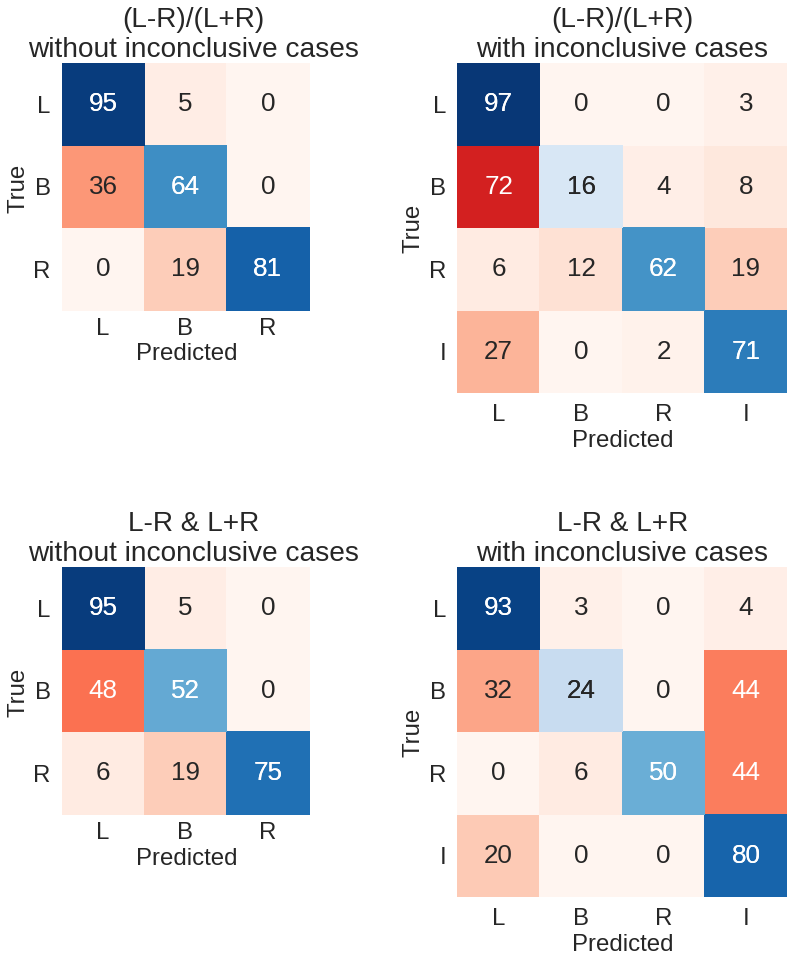

In [33]:
# show accuracies and significance
fig = plt.figure(figsize=(13, 17))

i = 1
for dim in [1, 2]:

    dimStr = ['1d', '2d'][dim - 1]

    for myDrop in [True, False]:
        dropStr = ['full', 'drop'][myDrop]
        print dimStr, dropStr

        testDf = makeDf(dimStr, dropStr)

        predDf = pd.DataFrame(testDf.idxmax(axis=1))
        print predDf.shape
        predDf.columns = ['pred']
        predDf.sort_index(inplace=True)

        ax = plt.subplot(2, 2, i)

        dTitle1 = {'1d': '(L-R)/(L+R)', '2d': 'L-R & L+R'}
        dTitle2 = {
            True: 'without inconclusive cases',
            False: 'with inconclusive cases'
        }
        ax.set_title(dTitle1[dimStr] + '\n' + dTitle2[myDrop], fontsize=28)
        
        ax = makeCmAx(predDf, ax)
    
        # if there are only three classes, change the way the ticks are plotted
        if myDrop:
            ax.tick_params(axis="x",direction="in", pad=-75) # move inwards

            # remove inc category
            ax.set_xticklabels(ax.get_xticklabels()[:-1])
            ax.set_yticklabels(ax.get_yticklabels()[1:])
            ax.set_yticks(np.arange(1.5,4,1))
            
            # move label towards center of new, smaller plot
            ax.set_ylabel(ax.get_ylabel(),y=.62)
            ax.xaxis.set_label_coords(0.38, 0.15) 
            
            ax.set_title(dTitle1[dimStr] + '\n' + dTitle2[myDrop], fontsize=28, x=0.4)

        i += 1

fig.savefig(
    '../reports/figures/10-test-set-cms.png', dpi=300, bbox_inches='tight')
plt.show()